In [60]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

from pyclustering.cluster.kmedians import kmedians

from pyclustering.utils import draw_clusters
from pyclustering.utils import read_sample
from pyclustering.utils import timedcall

import seaborn as sn

sn.set_theme()

def kmedians_clustering(k, data, iterations = 20, tolerance = 0.001):
    start_centroids = data[np.random.choice(data.shape[0], k, replace=False), :]
    min_instance = kmedians(data, start_centroids, tolerance)
    (ticks, result) = timedcall(min_instance.process)
    min_sse = min_instance.get_total_wce()

    for i in range(iterations):
        start_centroids = data[np.random.choice(data.shape[0], k, replace=False), :]
        kmedians_instance = kmedians(data, start_centroids, tolerance)
        (ticks, result) = timedcall(kmedians_instance.process)

        this_sse = kmedians_instance.get_total_wce()
        if (this_sse < min_sse):
            min_instance = kmedians_instance
            min_sse = this_sse

    return min_instance

def get_kmedians_labels(df, kmedians_instance):
    num_entries, num_features = df.shape
    clusters = kmedians_instance.get_clusters()
    cluster_labels=np.empty(shape=(num_entries,))
    for clus_ind in range(len(clusters)):
        clus = clusters[clus_ind]
        for j in range(len(clus)):
            point = clus[j]
            cluster_labels[point] = clus_ind

    return cluster_labels

def plot_indicators(sse_list, sil_list, sep_list):
    # SSE
    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.ylabel('SSE')
    plt.xlabel('K')
    plt.xticks(range(2, len(sse_list) + 2))
    plt.savefig("../images/alternative_clustering/kmeans_sse.png")
    plt.show()

    # Silhouette
    plt.plot(range(2, len(sil_list) + 2), sil_list)
    plt.ylabel('Silouettes')
    plt.xlabel('K')
    plt.xticks(range(2, len(sil_list) + 2))
    plt.savefig("../images/alternative_clustering/kmeans_silouettes.png")
    plt.show()

    # Davies-Bouldin Score
    plt.plot(range(2, len(sep_list) + 2), sep_list)
    plt.ylabel('Separation')
    plt.xlabel('K')
    plt.xticks(range(2, len(sep_list) + 2))
    plt.savefig("../images/alternative_clustering/kmeans_separation.png")
    plt.show()

def k_medians(df, max_k):
    sse_list = list()
    separations = list()
    silouettes = list()

    num_entries, num_features = df.shape
    points = np.zeros((num_entries, num_features))
    for i in range(num_entries):
        for j in range(num_features):
            points[i][j] = df.iloc[i, j]
    
    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Iterating over {0} possible K values".format(max_k)):        
        kmedians_instance = kmedians_clustering(k, points, iterations=1)
        
        cluster_labels = get_kmedians_labels(df, kmedians_instance)
                
        separations.append(davies_bouldin_score(df, cluster_labels))
        silouettes.append(silhouette_score(df, cluster_labels))
        sse = kmedians_instance.get_total_wce()
        sse_list.append(sse)
    
    return sse_list, silouettes, separations

In [2]:
%%time
datasetPath = "../dataset/users_clean_with_indicators_no_outliers.h5"
df_users = pd.read_hdf(datasetPath)

CPU times: user 120 ms, sys: 32.8 ms, total: 152 ms
Wall time: 198 ms


In [3]:
df_clustering = df_users.copy()

In [4]:
# delete categorical attributes
del df_clustering['name']
del df_clustering['lang']
del df_clustering['bot']
del df_clustering['created_at']

In [5]:
df_clustering.statuses_count = np.log(df_clustering.statuses_count + 1)
df_clustering.tweet_count = np.log(df_clustering.tweet_count + 1)
df_clustering.retweet_made = np.log(df_clustering.retweet_made + 1)
df_clustering.retweet_made_ratio = np.log(df_clustering.retweet_made_ratio + 1)
df_clustering.reply_count_avg = np.log(df_clustering.reply_count_avg + 1)
df_clustering.favorite_count_avg = np.log(df_clustering.favorite_count_avg + 1)
df_clustering.num_hashtags_avg = np.log(df_clustering.num_hashtags_avg + 1)
df_clustering.num_urls_avg = np.log(df_clustering.num_urls_avg + 1)
df_clustering.num_mentions_avg = np.log(df_clustering.num_mentions_avg + 1)
df_clustering.tweet_length_avg = np.log(df_clustering.tweet_length_avg + 1)
df_clustering.num_special_chars_avg = np.log(df_clustering.num_special_chars_avg + 1)
df_clustering.reply_count_entropy = np.log(df_clustering.reply_count_entropy + 1)
df_clustering.favorite_count_entropy = np.log(df_clustering.favorite_count_entropy + 1)
df_clustering.num_hashtags_entropy = np.log(df_clustering.num_hashtags_entropy + 1)
df_clustering.num_urls_entropy = np.log(df_clustering.num_urls_entropy + 1)
df_clustering.tweet_length_entropy = np.log(df_clustering.tweet_length_entropy + 1)

In [6]:
df_clustering = df_clustering[["statuses_count", "retweet_made_ratio", "elapsed_time_entropy"]].copy()

In [7]:
df_clustering.describe()

,statuses_count,retweet_made_ratio,elapsed_time_entropy
count,11508.000000,11508.000000,11508.000000
mean,5.606388,0.080843,2.472382
std,2.634090,0.135644,1.199069
min,0.000000,0.000000,0.000000
25%,3.761200,0.000000,1.324296
50%,4.276666,0.000000,2.540036
75%,7.832510,0.117783,3.479779
max,12.898109,0.693147,5.757547


In [8]:
df_clustering.head()

,statuses_count,retweet_made_ratio,elapsed_time_entropy
2.353594e+09,4.343805,0.000000,1.364257
2.358851e+09,4.007333,0.000000,1.335474
1.379596e+08,1.386294,0.000000,0.693147
4.661248e+08,3.931826,0.004695,4.130876
2.571494e+09,8.865876,0.000000,2.868727


In [61]:
sse, sil, davies_bouldin = k_medians(df_clustering, 15)

Iterating over 15 possible K values: 100%|██████████| 14/14 [01:25<00:00,  6.08s/it]


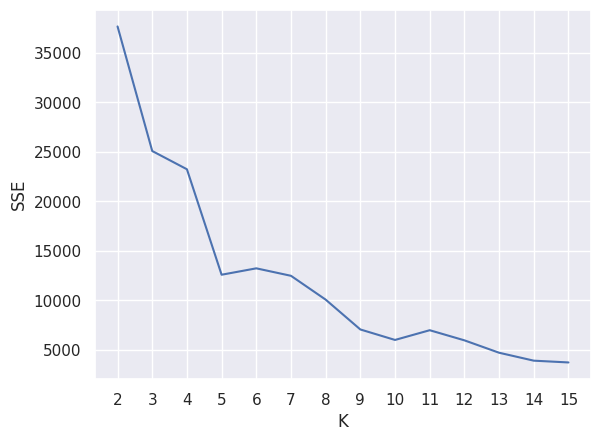

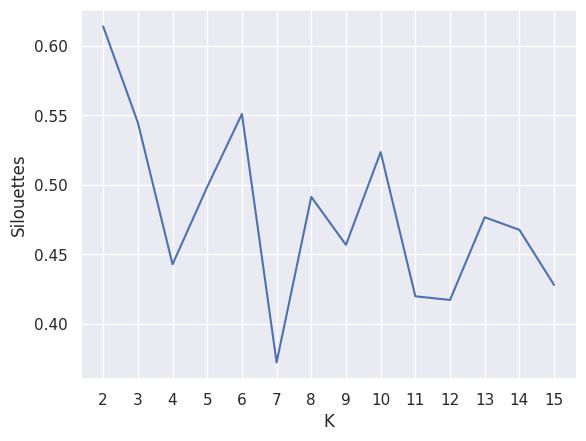

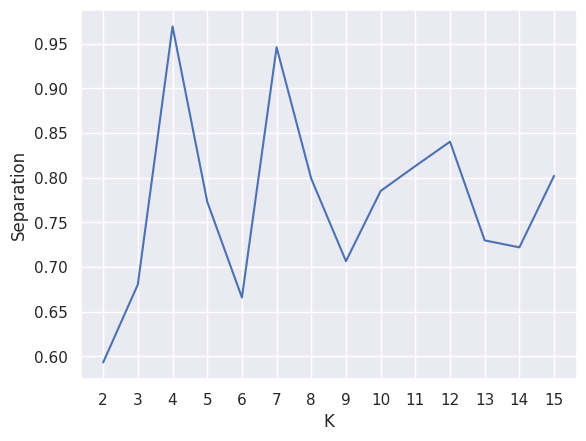

In [62]:
plot_indicators(sse, sil, davies_bouldin)

In [73]:
best_k = 4  # best k value
num_entries, num_features = df_clustering.shape
points = np.zeros((num_entries, num_features))
for i in range(num_entries):
    for j in range(num_features):
        points[i][j] = df_clustering.iloc[i, j]

kmedians_instance = kmedians_clustering(best_k, points, iterations=1)
cluster_labels = get_kmedians_labels(df_clustering, kmedians_instance)

print("SSE:", sse[best_k-2], " - SILHOUETTE:", sil[best_k-2])
print("THIS RUN SILHOUETTE:", silhouette_score(df_clustering, cluster_labels))
print("THIS RUN SSE:", kmedians_instance.get_total_wce())

SSE: 23238.26773698781  - SILHOUETTE: 0.4427528473464911
THIS RUN SILHOUETTE: 0.4462610356022383
THIS RUN SSE: 22626.65362494406


In [74]:
df_cluster = df_clustering.copy()
df_cluster["cluster"] = cluster_labels  # insert the column "cluster"
df_cluster.groupby("cluster").mean()

,statuses_count,retweet_made_ratio,elapsed_time_entropy
cluster,,,
0.0,9.532821,0.188300,2.572748
1.0,7.427427,0.155007,2.806403
2.0,3.704751,0.013368,1.269097
3.0,4.060509,0.046504,3.519913


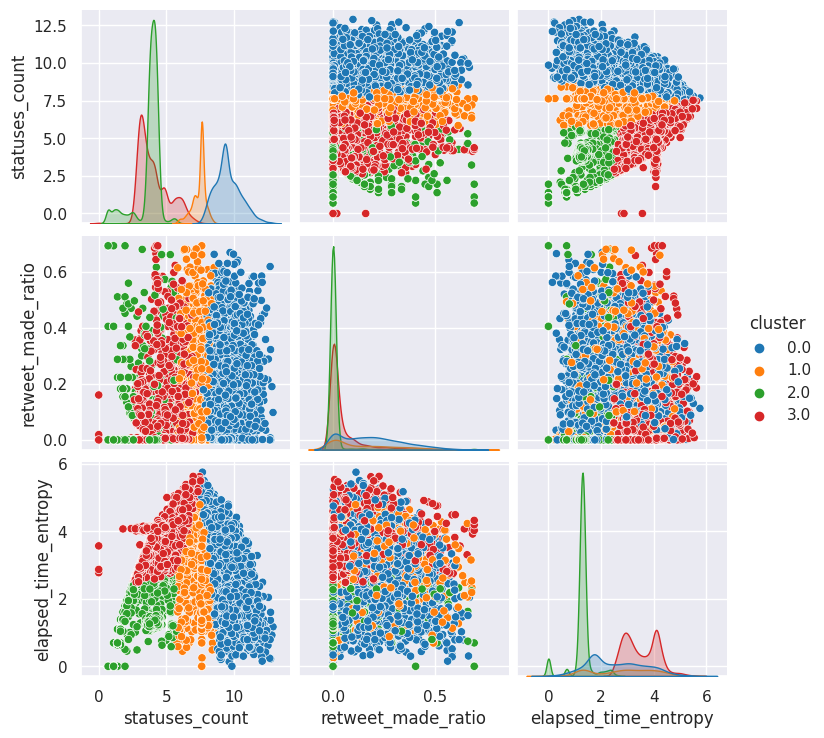

In [75]:
sn.pairplot(df_cluster, hue='cluster', palette='tab10')

<AxesSubplot: xlabel='PC_1', ylabel='PC_2'>

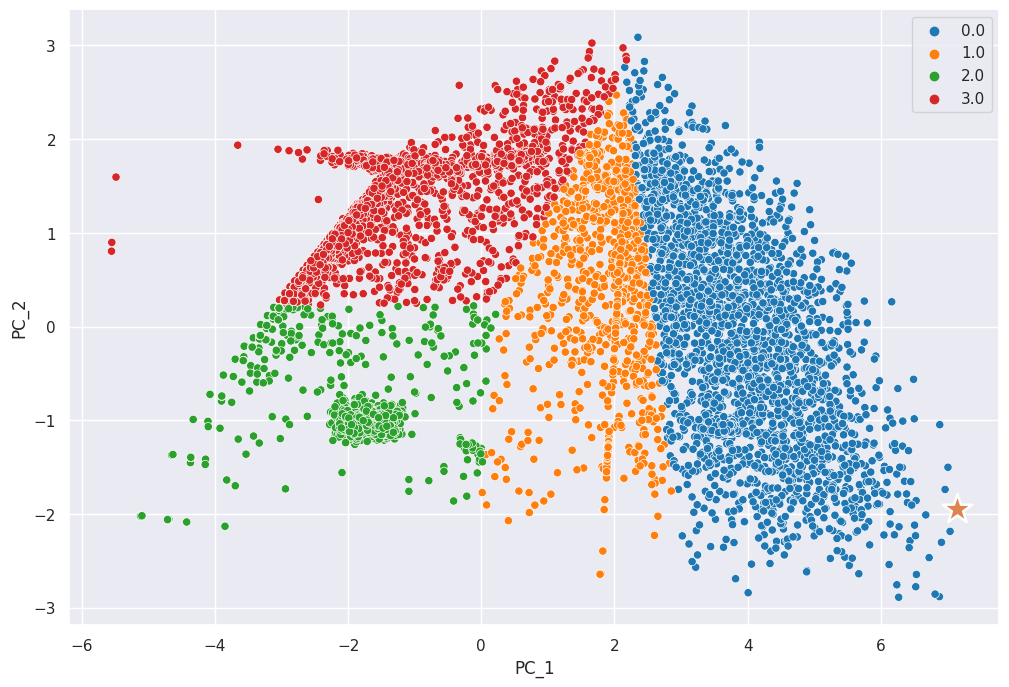

In [77]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(df_clustering), columns=['PC_1','PC_2'], index=df_clustering.index)
data_to_visualize['cluster'] = pd.Categorical(cluster_labels)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize, palette='tab10')

max_statuses_count_user = df_clustering[df_clustering.statuses_count == df_clustering.statuses_count.max()]
a = data_to_visualize.loc[max_statuses_count_user.index, 'PC_1']
b = data_to_visualize.loc[max_statuses_count_user.index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
#plt.text(x=a-3, y=b-0.14, s="Gustavo Milan", fontdict=dict(color='black', alpha=0.5, size=16))

## MinMax

In [78]:
scaler = MinMaxScaler()
X_minmax = pd.DataFrame(scaler.fit_transform(df_clustering.values))

In [79]:
sse_minmax, sil_minmax, davies_bouldin_minmax = k_medians(X_minmax, 20)

Iterating over 20 possible K values: 100%|██████████| 19/19 [02:08<00:00,  6.77s/it]


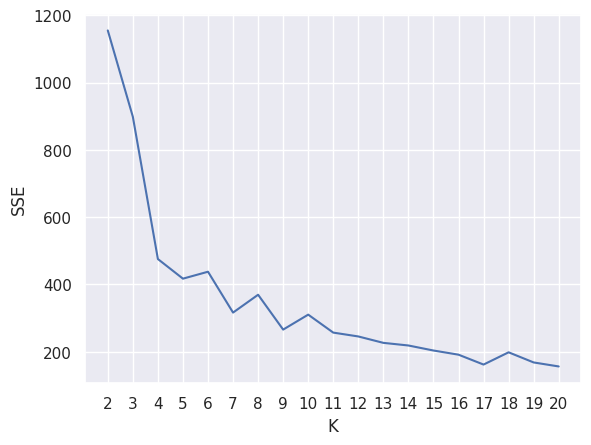

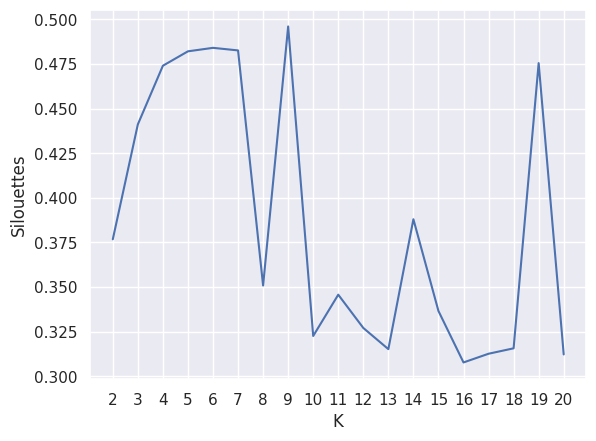

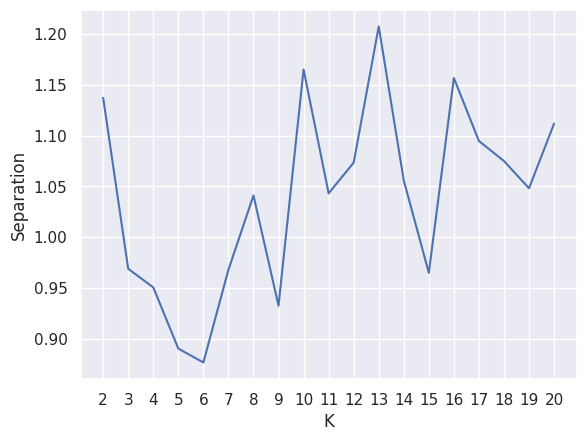

In [80]:
plot_indicators(sse_minmax, sil_minmax, davies_bouldin_minmax)

In [87]:
best_k = 6  # best k value
num_entries, num_features = X_minmax.shape
points = np.zeros((num_entries, num_features))
for i in range(num_entries):
    for j in range(num_features):
        points[i][j] = X_minmax.iloc[i, j]

kmedians_instance = kmedians_clustering(best_k, points, iterations=1)
print("SSE:", sse[best_k-2], " - SILHOUETTE:", sil[best_k-2])
print("THIS RUN SILHOUETTE:", silhouette_score(df_clustering, cluster_labels))
print("THIS RUN SSE:", kmedians_instance.get_total_wce())

SSE: 13232.464051673245  - SILHOUETTE: 0.5509846877533872
THIS RUN SILHOUETTE: 0.43451648130609016
THIS RUN SSE: 370.61045107210754


In [88]:
cluster_labels = get_kmedians_labels(X_minmax, kmedians_instance)
df_cluster["cluster"] = cluster_labels  # insert the column "cluster"
df_cluster.groupby("cluster").mean()

,statuses_count,retweet_made_ratio,elapsed_time_entropy
cluster,,,
0.0,8.916116,0.378620,2.128605
1.0,9.205802,0.056330,1.917321
2.0,4.208998,0.002594,1.329122
3.0,3.140942,0.005779,1.127307
4.0,3.955638,0.022504,3.416150
5.0,7.779032,0.191523,3.981489


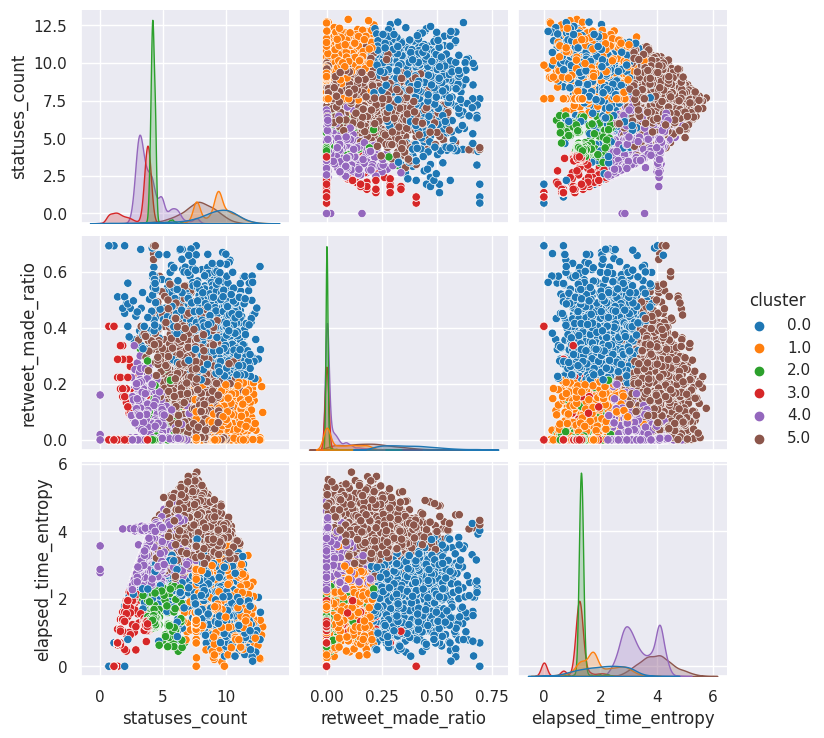

In [89]:
sn.pairplot(df_cluster, hue='cluster', palette='tab10')

## Standard Scaler

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(df_clustering.values))

In [ ]:
sse_std, sil_std, davies_bouldin_std = k_medians(X_std, 20)

In [ ]:
plot_indicators(sse_std, sil_std, davies_bouldin_std)

In [ ]:
best_k = 6  # best k value
num_entries, num_features = X_minmax.shape
points = np.zeros((num_entries, num_features))
for i in range(num_entries):
    for j in range(num_features):
        points[i][j] = X_minmax.iloc[i, j]

kmedians_instance = kmedians_clustering(best_k-2, points, iterations=1)
print("SSE:", sse[best_k-2], " - SILHOUETTE:", sil[best_k-2])
print("THIS RUN SILHOUETTE:", silhouette_score(df_clustering, cluster_labels))
print("THIS RUN SSE:", kmedians_instance.get_total_wce())